In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# define our model
input1 = Input(shape=(28,28,1))
input2 = Input(shape=(28,28,1))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)


In [4]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# fit the model
model.fit([x_train, x_train], y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 70s 37ms/step - loss: 0.1631 - accuracy: 0.9514
Epoch 2/3
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0644 - accuracy: 0.9797
Epoch 3/3
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0439 - accuracy: 0.9860


In [6]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 20.1 MB/s 


In [7]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train, x_train])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([x_test[:3], x_test[:3]])

In [8]:
# since the model has 10 outputs we get a list of 10 explanations (one for each output)
print(len(shap_values))

10


In [9]:
# since the model has 2 inputs we get a list of 2 explanations (one for each input) for each output
print(len(shap_values[0]))

2


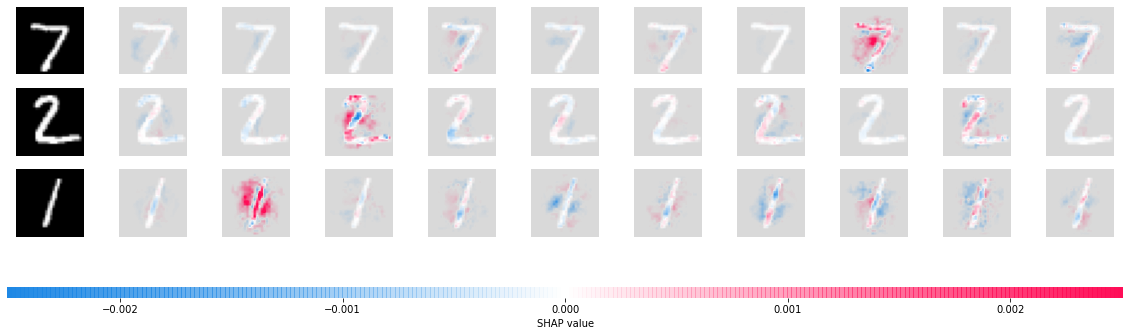

In [10]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(10)], x_test[:3])

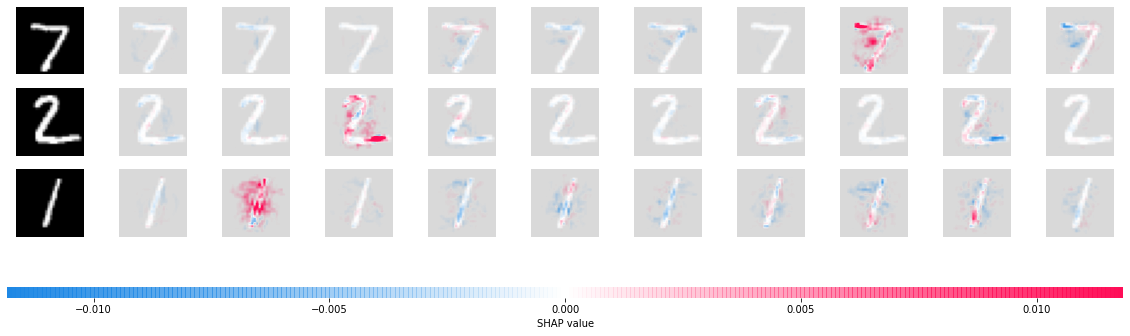

In [11]:
# here we plot the explanations for all classes for the second input (this is the conv-net input)
shap.image_plot([shap_values[i][1] for i in range(10)], x_test[:3])

In [12]:
# get the variance of our estimates
shap_values, shap_values_var = explainer.shap_values([x_test[:3], x_test[:3]], return_variances=True)


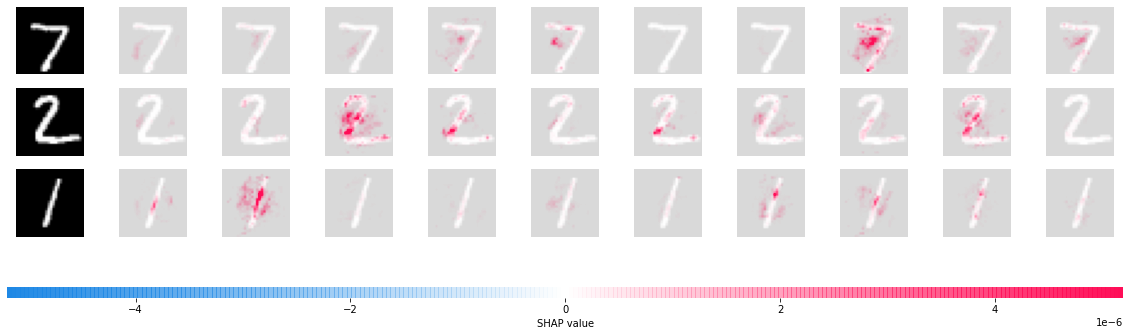

In [13]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values_var[i][0] for i in range(10)], x_test[:3])

In [14]:
#Census income classification with Keras

In [15]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding
from tqdm import tqdm
import shap

# print the JS visualization code to the notebook
#shap.initjs()

In [16]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [17]:
# build model
input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)


In [26]:
# train model
clf = Model(inputs=input_els, outputs=[out])
clf.compile(optimizer="adam", loss='binary_crossentropy')
clf.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=5,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Epoch 1/5
51/51 [==============================] - 2s 10ms/step - loss: 0.8947 - val_loss: 0.4595
Epoch 2/5
51/51 [==============================] - 0s 6ms/step - loss: 0.7641 - val_loss: 0.4469
Epoch 3/5
51/51 [==============================] - 0s 6ms/step - loss: 0.6566 - val_loss: 0.4571
Epoch 4/5
51/51 [==============================] - 0s 6ms/step - loss: 0.6099 - val_loss: 0.4391
Epoch 5/5
51/51 [==============================] - 0s 6ms/step - loss: 0.5697 - val_loss: 0.4216


In [27]:
def f(X):
    return clf.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [28]:
# print the JS visualization code to the notebook
shap.initjs()

In [21]:
explainer = shap.KernelExplainer(f, X.iloc[:50,:])
shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)


In [22]:
shap_values50 = explainer.shap_values(X.iloc[280:285,:], nsamples=500)

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
shap_values

array([ 0.03580029,  0.00062767, -0.12449902, -0.0139896 ,  0.00942844,
       -0.28565187,  0.00122957,  0.        , -0.01813494, -0.00144652,
        0.27667946,  0.00176258])

In [24]:
import warnings
warnings.filterwarnings("ignore")
# summarize the effects of all the features
shap_values50 = explainer.shap_values(X.iloc[280:781,:], nsamples=500)

  0%|          | 0/501 [00:00<?, ?it/s]

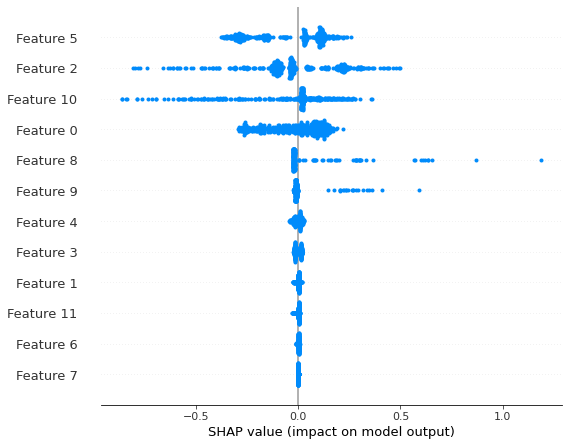

In [25]:
shap.summary_plot(shap_values50)

In [32]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.3 MB/s 


In [33]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [34]:
dataset_path = "https://raw.githubusercontent.com/pradmishra1/PublicDatasets/main/titanic.csv"

In [35]:
titanic_data = pd.read_csv(dataset_path)

In [36]:
titanic_data.columns
del titanic_data['Unnamed: 0']
del titanic_data['PassengerId']

In [37]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="class")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass'], axis=1)

In [38]:
# Set random seed for reproducibility.
np.random.seed(707)

# Convert features and labels to numpy arrays.
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [39]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [40]:
net = TitanicSimpleNNModel()
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)


In [41]:
for epoch in range(num_epochs):
  output = net(input_tensor)
  loss = criterion(output, label_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))
torch.save(net.state_dict(), '/model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.58
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.48
Epoch 81/200 => Loss: 0.47
Epoch 101/200 => Loss: 0.46
Epoch 121/200 => Loss: 0.46
Epoch 141/200 => Loss: 0.46
Epoch 161/200 => Loss: 0.46
Epoch 181/200 => Loss: 0.45


In [42]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8651685393258427


In [43]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.835820895522388


In [44]:
ig = IntegratedGradients(net)

In [45]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [46]:
np.round(attr,2)

array([[-0.  , -0.  , -0.  , ...,  0.  ,  0.  , -0.  ],
       [-8.75, -0.  , -0.  , ...,  0.  ,  0.  , -2.41],
       [-0.  , -0.  , -0.  , ...,  0.  ,  0.  , -0.  ],
       ...,
       [-0.89,  0.  , -0.  , ...,  0.52, -0.  ,  0.  ],
       [-0.85, -0.  ,  0.  , ...,  0.  ,  0.  ,  0.06],
       [-1.56,  0.  , -0.  , ...,  0.  ,  0.  , -0.05]])

In [47]:
importances = np.mean(attr, axis=0)

In [48]:
for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))

Age :  -1.243
SibSp :  -0.042
Parch :  -0.006
Fare :  0.479
female :  0.186
male :  -0.120
embark_C :  0.021
embark_Q :  0.015
embark_S :  0.033
class_1 :  0.081
class_2 :  0.029
class_3 :  -0.093


In [49]:
cond = LayerConductance(net, net.sigmoid1)

In [50]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

In [51]:
Average_Neuron_Importances = np.mean(cond_vals, axis=0)
Average_Neuron_Importances

array([ 0.00149701, -0.2790788 ,  0.00217723,  0.00106298, -0.05221153,
       -0.01386507,  0.00102999, -0.11549971, -0.06775784, -0.03011038,
       -0.08684643,  0.00123045], dtype=float32)

In [52]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [53]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)

In [54]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

In [55]:
# Average Feature Importances for Neuron 0
nn0 = neuron_cond_vals_0.mean(dim=0).detach().numpy()
np.round(nn0,3)

array([ 0.001, -0.   ,  0.   ,  0.001, -0.   ,  0.   ,  0.   , -0.   ,
        0.   ,  0.   ,  0.   ,  0.   ], dtype=float32)